### MNIST: Deep Convolutional (DC) Generative Adversarial Network (GAN)

### Install/Load Dependencies

In [3]:
%%capture
# pip install requierment to run a dependency in code
!pip install "wheel == 0.34.2"

# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from six.moves import urllib # to avoid file download error
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
import time
from google.colab import drive



### Training Parameters


In [5]:
num_epochs = 10
batch_size = 64
learning_rate = 2e-4
use_gpu = True
img_size = 64
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

### Load MNIST Data

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


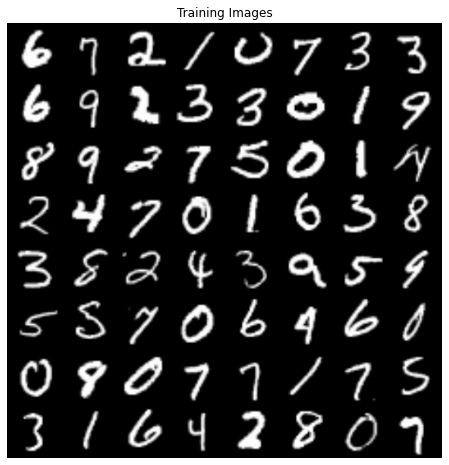

In [6]:
# define transformer for dataloader
# resize and normalize data for slight performance boost
img_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# file download error quick fix
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

### Custom weight initialization

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [8]:
# number of channels (for gray = 1 , for RGB = 3)
nc = 1
# number/size of latent vector z for the generator input
nz = 100
# size/number of feature maps in generator
ngf = 128
# size/number of feature maps in discriminator
ndf = 128
# define fixed noise to sample images from the latent space of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # input to conv. lay. : length of latent vector z 
        self.deconv1 = nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False)
        self.deconv1_bn = nn.BatchNorm2d(ngf*8)
        # state size: (ngf * 8) x 4 x 4
        self.deconv2 = nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)
        self.deconv2_bn = nn.BatchNorm2d(ngf*4)
        # state size: (ngf * 4) x 8 x 8
        self.deconv3 = nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False)
        self.deconv3_bn = nn.BatchNorm2d(ngf*2)
        # state size: (ngf * 2) x 16 x 16
        self.deconv4 = nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False)
        self.deconv4_bn = nn.BatchNorm2d(ngf)
        # state size: (ngf) x 32 x 32
        self.deconv5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        # state size: (nc) x 64 x 64

    def forward(self, input):
        x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input to conv. lay. : (nc) x 64 x 64
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv1_bn = nn.BatchNorm2d(ndf)
        # state size: (ndf) x 32 x 32
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
        self.conv2_bn = nn.BatchNorm2d(ndf*2)
        # state size: (ndf * 2) x 16 x 16
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)
        self.conv3_bn = nn.BatchNorm2d(ndf*4)
        # state size: (ndf * 4) x 8 x 8
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)
        self.conv4_bn = nn.BatchNorm2d(ndf*8)
        # state size: (ndf * 8) x 4 x 4
        self.conv5 = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input))
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x
    
generator = Generator()
discriminator = Discriminator()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02
#generator.apply(weights_init)
#discriminator.apply(weights_init)


device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12654336 and discriminator: 11032320


### Define Storage Location

In [10]:
# mount google drive for saving checkpoints
drive.mount('/content/drive')

# checkpoint generator file name
gen_save_name = 'mnist_gen.cpt'
# define location to store checkpoints for generator
path_gen = F'/content/drive/My Drive/{gen_save_name}'

# checkpoint discriminator file name
disc_save_name = 'mnist_disc.cpt'
# define location to store checkpoints for discriminator
path_disc = F'/content/drive/My Drive/{disc_save_name}'

Mounted at /content/drive


Train GAN
--------


In [38]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# set to training mode
generator.train()
discriminator.train()

gen_iter_loss = []
disc_iter_loss = []

gen_loss_avg = []
disc_loss_avg = []
iters = 0

# store generated images 
img_lst = []
# store generated images for gif
img_lst_gif = []
# store one image for every epoch to calculate inception score
img_inception_score = []

print('Training ...')
for epoch in range(3):
    # start countine time 
    start_time = time.time() 
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    #for image_batch, _ in tqdm(train_dataloader):
    #for i, data in enumerate(dataloader, 0):
    #for image_batch, _ in train_dataloader: # this is orgiginal
    for image_batch, i in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), nz, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        # store loss per iteration
        gen_iter_loss.append(gen_loss.item())
        disc_iter_loss.append(disc_loss.item())

        # average loss per iteration to obtain average loss per epoch
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        # every 104 batches give print statement
        if num_batches % 104 == 0 :
            print('Epoch [%d / %d], batch [%d / %d]: average loss generator vs. discrim.: %f vs. %f [%s seconds]' %
          (epoch+1, num_epochs, num_batches, len(train_dataloader), gen_loss_avg[-1], disc_loss_avg[-1], round(time.time() - start_time,3)))
        
        # Save generated image if: 
        # 1) at the first iteration
        # 2) 250 iterations have passed each time
        # 2) final epoch has been reached
        # 3) a full batch of training passed i.e one epoch has passed each time
        # 4) 1 epoch passed for inception score
        elif (iters == 0) or (epoch == num_epochs) or (iters % len(train_dataloader) == 0):
            # turn off gradient descent computation to minimize computation cost
            with torch.no_grad():
                # generate fake image from generator
                fake = generator(fixed_noise).detach().cpu()
            # store image
            img_lst.append(fake)
            # store image for gif
            img_lst_gif.append(vutils.make_grid(fake, padding=2, normalize=True))
            print('No. of sample images stored: [%d]' % len(img_lst))
        elif (iters % 2 == 0) :
            # turn off gradient descent computation to minimize computation cost
            with torch.no_grad():
                # generate fake image from generator
                fake = generator(fixed_noise).detach().cpu()
            # store image
            img_inception_score.append(fake)
            #print('added image to inception score list for epoch ', iters)
        iters += 1
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    # after each epoch print current epoch, generator and discriminator loss and runtime per epoch
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f [%s seconds]'  %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1], round(time.time() - start_time,3)))
    # after each epoch save generator, epochs, loss and images
    print('Generator Checkpoint Saved [%d / %d]' % (epoch + 1, num_epochs))
    torch.save({
            'epoch': epoch,
            'gen_state_dict': generator.state_dict(),
            'optimizer_state_dict': gen_optimizer.state_dict(),
            'gen_loss_avg': gen_loss_avg,
            'gen_iter_loss': gen_iter_loss,
            'img_lst':img_lst,
            'img_lst_gif': img_lst_gif,
            }, path_gen)
    # after each epoch save discriminator, epochs and loss
    print('Discriminator Checkpoint Saved [%d / %d]' % (epoch + 1, num_epochs))
    torch.save({
            'epoch': epoch,
            'disc_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': disc_optimizer.state_dict(),
            'disc_loss_avg': disc_loss_avg,
            'disc_iter_loss': disc_iter_loss,
            }, path_disc)

Training ...
No. of sample images stored: [1]
Epoch [1 / 10], batch [104 / 938]: average loss generator vs. discrim.: 218.191274 vs. 50.562764 [98.202 seconds]
Epoch [1 / 10], batch [208 / 938]: average loss generator vs. discrim.: 419.197372 vs. 102.522499 [196.363 seconds]
Epoch [1 / 10], batch [312 / 938]: average loss generator vs. discrim.: 648.389377 vs. 147.893376 [294.462 seconds]
Epoch [1 / 10], batch [416 / 938]: average loss generator vs. discrim.: 911.303260 vs. 191.048618 [392.495 seconds]
Epoch [1 / 10], batch [520 / 938]: average loss generator vs. discrim.: 1132.939610 vs. 237.799326 [490.567 seconds]
Epoch [1 / 10], batch [624 / 938]: average loss generator vs. discrim.: 1387.955417 vs. 281.451964 [588.613 seconds]


KeyboardInterrupt: ignored

### Load Checkpoints

### Figures: First and Last Image

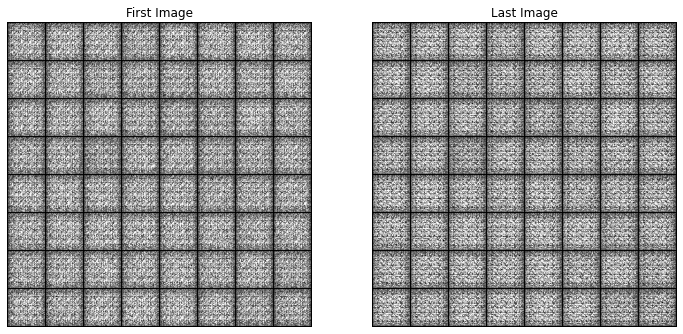

In [12]:
# plot of generated image
# plot 1st image
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("First Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
# plot last image
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Last Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[-1].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

### Gif: Image Generation Process

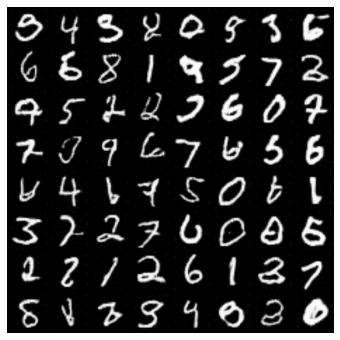

In [ ]:
# gif from starting image to last generated image
#%%capture
# if bytes for gif are too big increase limit 
# plt.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(6,6))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu().numpy(),(1,2,0)), animated=True)] for i in img_lst_gif]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

### Training Curves
--------------------

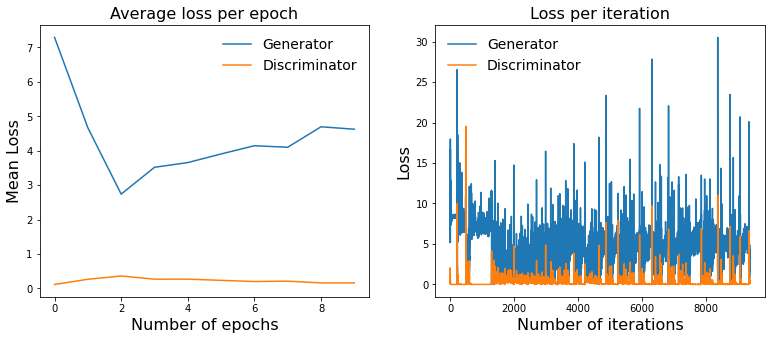

In [ ]:
# Plot average loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(gen_loss_avg, linewidth=1.5)
plt.plot(disc_loss_avg, linewidth=1.5)
plt.title('Average loss per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Mean Loss', fontsize = 16)
plt.legend(['Generator', 'Discriminator'], 
           prop={'size': 14},           
            frameon=False)

# Plot loss per iteration
plt.subplot(1,2,2)
plt.plot(gen_iter_loss, linewidth=1.5)
plt.plot(disc_iter_loss, linewidth=1.5)
plt.title('Loss per iteration', fontsize = 16)
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.legend(['Generator', 'Discriminator'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

### Plot: Batch of Fake Images

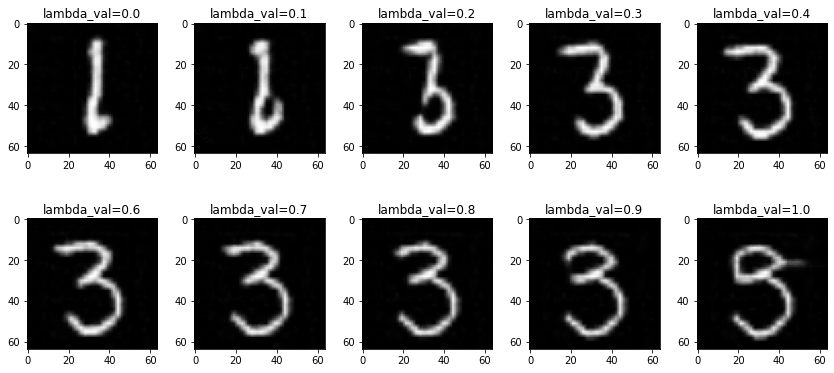

In [ ]:
# plots a heatmap gray colored
plt.ion()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, nz, 1, 1, device=device)
latent_2 = torch.randn(1, nz, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
    # heatmap gray color
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

### Plot: Batch of Real vs. Fake Images

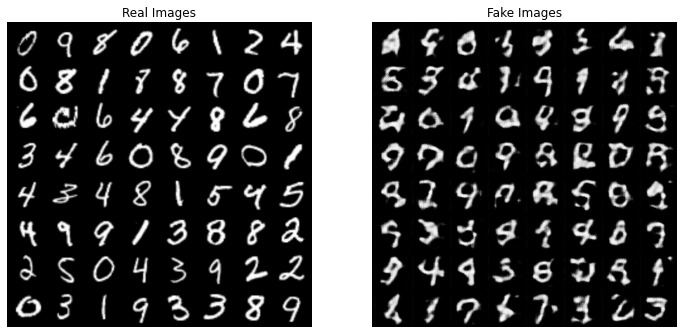

In [39]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_lst_gif[-1].cpu().numpy(),(1,2,0)))
plt.show()

### Plot: Grid of Generate Images

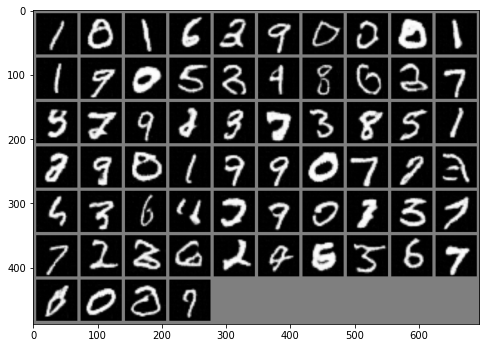

In [ ]:
plt.ion()
generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution here gaussian noise
    fake_image_batch = generator(fixed_noise)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()



```
# Dit is opgemaakt als code
```

# IS: Inception Score

In [20]:
from torchvision.models.inception import inception_v3
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [4]:
print(len(img_inception_score))

stedv, means = [], []

for j in range(len(img_inception_score)):
  imgs = []
  for i in range(len(img_inception_score[j])):
    imgs.append((vutils.make_grid(img_inception_score[j][i].to(device), padding=2, normalize=True).cpu()))
  mean, stdv = inception_score(imgs, cuda=True, batch_size=1, resize=True, splits=1)
  means.append(mean)
  stedv.append(stdv)

NameError: ignored

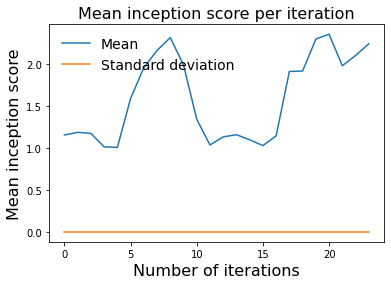

In [ ]:
# Plot mean inception score per iteration
plt.plot(means, linewidth=1.5)
plt.plot(stedv, linewidth=1.5)
plt.title('Mean inception score per iteration', fontsize = 16)
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Mean inception score', fontsize = 16)
plt.legend(['Mean', 'Standard deviation'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

# FID: Frechet Inception Distance

In [44]:
# example of calculating the frechet inception distance in Keras for cifar10
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
def FID(image_lst_part): 
  # prepare the inception v3 model
  model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
  # load cifar10 images

  images1 = vutils.make_grid(image_lst_part.to(device)).cpu().detach().numpy()
  images2 = vutils.make_grid(real_batch[0].to(device)).cpu().detach().numpy()
  #print('Loaded', images1.shape, images2.shape)
  # convert integer to floating point values
  images1 = images1.astype('float32')
  images2 = images2.astype('float32')
  # resize images
  images1 = scale_images(images1, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  #print('Scaled', images1.shape, images2.shape)
  # pre-process images
  images1 = preprocess_input(images1)
  images2 = preprocess_input(images2)
  # calculate fid
  fid = calculate_fid(model, images1, images2)
  #print('FID: %.3f' % fid)
  return fid

In [45]:
fids = []
for i in range(len(img_lst)):
  fids.append(FID(img_lst[i]))

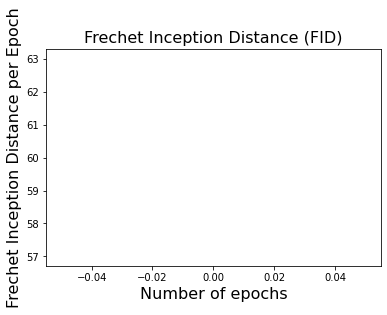

In [46]:
# Plot FID per epoch
plt.plot(fids, linewidth=1.5)
plt.title('Frechet Inception Distance (FID)', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Frechet Inception Distance per Epoch', fontsize = 16)

plt.show()

In [47]:
fids

[60.00537490849528]